# Multi-instrument analysis with the SunPy Ecosystem

- AIA
- EUI
- SPICE
- DKIST

Bonus:
- IRIS (?)
- EIS (?)
- SOT/SP (?)

The affiliated packages we will use are:

- `sunpy`
- `sunpy-soar`
- `dkist`
- `sunraster`

The interesting science question we will answer is...

- Observations from chromosphere (dkist) to TR (SPICE) to corona (AIA, EUI)
- How can additional FOV constraints tell us more about what DKIST is seeing?

In [19]:
from sunpy.net import Fido, attrs as attrs
import dkist.net
import sunpy_soar
import astropy.units as u
import sunpy.map
import sunraster
# import solarmach

from sunpy.coordinates import get_earth, get_horizons_coord

## Searching for and Downloading Data with `Fido`

### SDO/AIA

In [3]:
time_range = attrs.Time("2022-10-24T18:55", "2022-10-24T19:35")

In [4]:
aia_query = time_range & attrs.Instrument.aia & attrs.Wavelength(171*u.Angstrom) & attrs.Sample(10*u.minute)

In [13]:
q  = Fido.search(aia_query)

In [14]:
q

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2022-10-24 18:55:09.000,2022-10-24 18:55:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:05:09.000,2022-10-24 19:05:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:15:09.000,2022-10-24 19:15:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
2022-10-24 19:25:09.000,2022-10-24 19:25:10.000,SDO,AIA,171.0 .. 171.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844


### Solar Orbiter--EUI and SPICE

In [9]:
# eui_query = time_range & attrs.soar.Product('EUI-HRIEUV174-IMAGE') & attrs.Level(2)
# spice_query = time_range & attrs.soar.Product('SPICE-N-RAS') & attrs.Level(2)
solo_query = time_range & (attrs.soar.Product('EUI-HRIEUV174-IMAGE') | attrs.soar.Product('SPICE-N-RAS')) & attrs.Level(2)

In [11]:
q = Fido.search(solo_query)

In [12]:
q

Instrument,Data product,Level,Start time,End time,Data item ID,Filename,Filesize,SOOP Name
,,,,,,,Mbyte,
str3,str19,str2,str23,str23,str46,str55,float64,str30
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:55.174,2022-10-24 19:29:56.824,solo_L2_eui-hrieuv174-image_20221024T192955174,solo_L2_eui-hrieuv174-image_20221024T192955174_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:30.174,2022-10-24 19:29:31.824,solo_L2_eui-hrieuv174-image_20221024T192930174,solo_L2_eui-hrieuv174-image_20221024T192930174_V01.fits,5.679,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:29:10.174,2022-10-24 19:29:11.824,solo_L2_eui-hrieuv174-image_20221024T192910174,solo_L2_eui-hrieuv174-image_20221024T192910174_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:20:25.173,2022-10-24 19:20:26.823,solo_L2_eui-hrieuv174-image_20221024T192025173,solo_L2_eui-hrieuv174-image_20221024T192025173_V01.fits,5.504,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:28:40.174,2022-10-24 19:28:41.824,solo_L2_eui-hrieuv174-image_20221024T192840174,solo_L2_eui-hrieuv174-image_20221024T192840174_V01.fits,5.662,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:28:20.204,2022-10-24 19:28:21.854,solo_L2_eui-hrieuv174-image_20221024T192820204,solo_L2_eui-hrieuv174-image_20221024T192820204_V01.fits,5.659,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:27:55.188,2022-10-24 19:27:56.838,solo_L2_eui-hrieuv174-image_20221024T192755188,solo_L2_eui-hrieuv174-image_20221024T192755188_V01.fits,5.679,R_SMALL_MRES_MCAD_AR-Long-Term
EUI,EUI-HRIEUV174-IMAGE,L2,2022-10-24 19:27:35.189,2022-10-24 19:27:36.839,solo_L2_eui-hrieuv174-image_20221024T192735189,solo_L2_eui-hrieuv174-image_20221024T192735189_V01.fits,5.665,R_SMALL_MRES_MCAD_AR-Long-Term


### DKIST

In [15]:
dkist_query = time_range & attrs.Instrument('VISP')

In [16]:
q = Fido.search(dkist_query)

In [17]:
q

Start Time,End Time,Instrument,Wavelength,Bounding Box,Dataset ID,Dataset Size,Exposure Time,Primary Experiment ID,Primary Proposal ID,Stokes Parameters,Target Types,Number of Frames,Average Fried Parameter,Embargoed,Downloadable,Has Spectral Axis,Has Temporal Axis,Average Spectral Sampling,Average Spatial Sampling,Average Temporal Sampling
,,,nm,,,Gibyte,s,,,,,,,,,,,nm,arcsec,s
Time,Time,str4,float64[2],str32,str5,float64,float64,str9,str9,str4,str7[1],int64,float64,bool,bool,bool,bool,float64,float64,float64
2022-10-24T18:57:45.634,2022-10-24T19:33:26.865,VISP,630.2424776472172 .. 631.826964866207,"(233.36,-368.87),(212.1,-503.97)",BKEWK,5.0,48.00811267605634,eid_1_123,pid_1_123,IQUV,unknown,2752,0.11445240041497136,False,True,True,True,0.00162511509639976,0.04160701928854328,1070.6156795058157


### Combining them all...

In [26]:
q = Fido.search(aia_query | solo_query | dkist_query)

In [27]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x7f889de0c340>
Results from 4 Providers:

4 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 271.155 Mbyte

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-10-24 18:55:09.000 2022-10-24 18:55:10.000    SDO ...    FULLDISK 64.64844
2022-10-24 19:05:09.000 2022-10-24 19:05:10.000    SDO ...    FULLDISK 64.64844
2022-10-24 19:15:09.000 2022-10-24 19:15:10.000    SDO ...    FULLDISK 64.64844
2022-10-24 19:25:09.000 2022-10-24 19:25:10.000    SDO ...    FULLDISK 64.64844

360 Results from the SOARClient:

Instrument     Data product    Level ... Filesize           SOOP Name           
                                     ...  Mbyte                                 
---------- ------------------- ----- ... -------- ------------------------------
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.504 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.662 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.659 R_SMALL_MRES_MCAD_AR-Long-Term
       ...                 ...   ... ...      ...                            ...
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.682 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.694 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.697 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.679 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.639 R_SMALL_MRES_MCAD_AR-Long-Term
       EUI EUI-HRIEUV174-IMAGE    L2 ...    5.665 R_SMALL_MRES_MCAD_AR-Long-Term
Length = 360 rows

3 Results from the SOARClient:

Instrument Data product Level ... Filesize           SOOP Name           
                              ...  Mbyte                                 
---------- ------------ ----- ... -------- ------------------------------
     SPICE  SPICE-N-RAS    L2 ...  116.715 R_SMALL_MRES_MCAD_AR-Long-Term
     SPICE  SPICE-N-RAS    L2 ...  116.715 R_SMALL_MRES_MCAD_AR-Long-Term
     SPICE  SPICE-N-RAS    L2 ...  116.715 R_SMALL_MRES_MCAD_AR-Long-Term

1 Results from the DKISTClient:

       Start Time               End Time        ... Average Temporal Sampling
                                                ...             s            
----------------------- ----------------------- ... -------------------------
2022-10-24T18:57:45.634 2022-10-24T19:33:26.865 ...        1070.6156795058157

In [28]:
files = Fido.fetch(q, path='data/{instrument}')

Files Downloaded:  98%|█████████▊| 362/368 [00:37<00:00, 10.65file/s]



Files Downloaded: 100%|█████████▉| 367/368 [00:37<00:00, 11.03file/s]































Files Downloaded: 100%|██████████| 368/368 [00:38<00:00,  9.49file/s]


## Combined Fields of View

## Loading Data...

In [31]:
m_aia = sunpy.map.Map('data/AIA/aia_lev1_171a_2022_10_24t19_05_09_35z_image_lev1.fits')

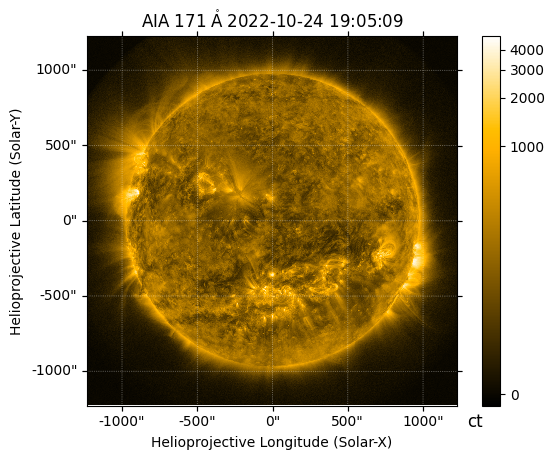

In [33]:
m_aia.peek()

In [34]:
m_eui = sunpy.map.Map('data/EUI/', sequence=True)

In [1]:
m_eui

NameError: name 'm_eui' is not defined